In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)


20.0

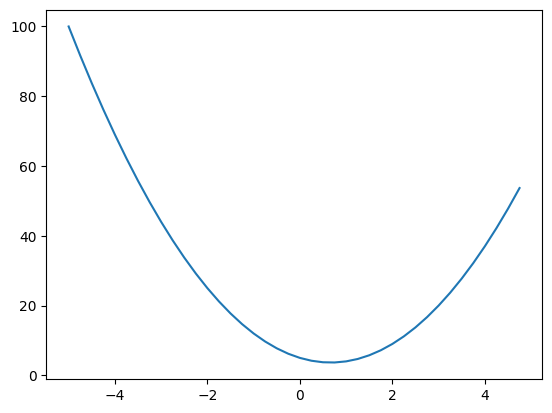

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [10]:
h = 0.0000001
x = 2/3
(f(x + h) - f(x)) / h

2.9753977059954195e-07

In [12]:
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(d)

4.0


In [16]:
h = 0.0001

b = -3.0
c = 10.0
d1 = a * b + c
c += h
d2 = a* b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1) / h)

d1 3.999699999999999
d2 3.9997999999999987
slope 0.9999999999976694


In [207]:
class Value:
    def __init__(self, data, _children=(), _op = '', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __radd__(self, other):
        return self + other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only support int/float"
        out = Value(self.data**other, (self,), f'**{other}')
        def _backward():
            self.grad = other * (self.data**(other -1)) * out.grad
        out._backward = _backward
        return out
    
    def __truediv__(self, other):
        return self * (other**-1)
    
    def __sub__(self, other):
        return self + (-1 * other)
    
    def __neg__(self):
        return self * -1
    
    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1) / (math.exp(2*n) + 1)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()

        def build(v):
            if v not in visited:
                visited.add(v)
                for c in v._prev:
                    build(c)
                topo.append(v)

        build(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10., label='c')
e = a*b; e.label = 'e'
d = e + c; d.label='d'
f = Value(-2.0, label = 'f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [183]:
a = Value(2)
a - 2
a - (a - 2)

Value(data=2)

In [43]:
d._op

'+'

In [28]:

from graphviz import Digraph

In [29]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges


In [39]:
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad, ), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
                     
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

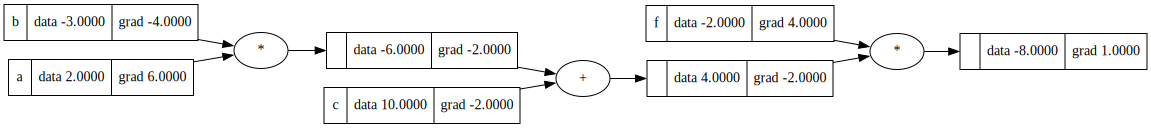

In [77]:
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0
e.grad = -2.0
c.grad = -2.0
a.grad = -3.0 * -2.0
b.grad = 2 * -2.0
draw_dot(L)

In [78]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-7.286496


In [71]:
def lol():
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10., label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.lable='d'
    f = Value(-2.0, label = 'f')
    L = d * f; L.label = 'L'
    L1 = L.data
    
    h = 0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0 + h, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    e.data
    d = e + c; d.lable='d'
    d.data 
    f = Value(-2.0, label = 'f')
    L = d * f; L.label = 'L'
    L2 = L.data 
    
    print((L2 - L1)/h)
    
lol()

-4.000000000008441


In [184]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

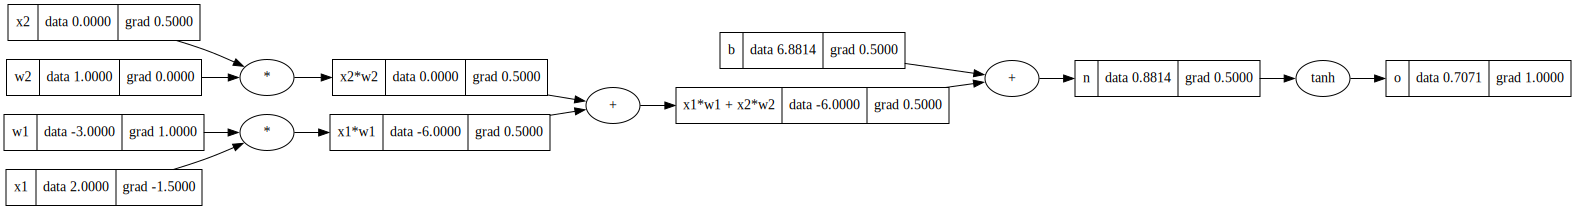

In [185]:
draw_dot(o)

In [152]:
o.backward()

In [147]:
o.grad = 1.0
topo = []
visited = set()

def build(v):
    if v not in visited:
        visited.add(v)
        for c in v._prev:
            build(c)
        topo.append(v)
    
build(o)

print(topo)

for node in reversed(topo):
    node._backward()

[Value(data=6.881373587019543), Value(data=0.0), Value(data=1.0), Value(data=0.0), Value(data=-3.0), Value(data=2.0), Value(data=-6.0), Value(data=-6.0), Value(data=0.8813735870195432), Value(data=0.7071067811865476)]


In [131]:
o.grad = 1.0
o._backward()

n._backward()
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()

In [110]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [112]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [105]:
x1w1x2w2.grad = 0.5

In [106]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [101]:
b.grad = 0.5

In [100]:
o.grad = 1.0

In [92]:
1 - o.data ** 2

0.4999999999999999

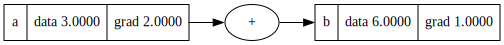

In [156]:
a = Value(3.0, label = 'a')
b = a + a ; b.label = 'b'
b.backward()
draw_dot(b)

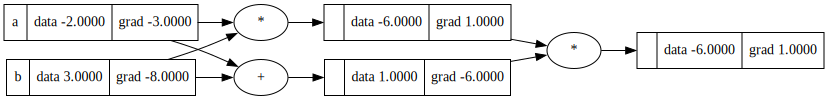

In [158]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b
e = a + b
f = d * e

f.backward()
draw_dot(f)

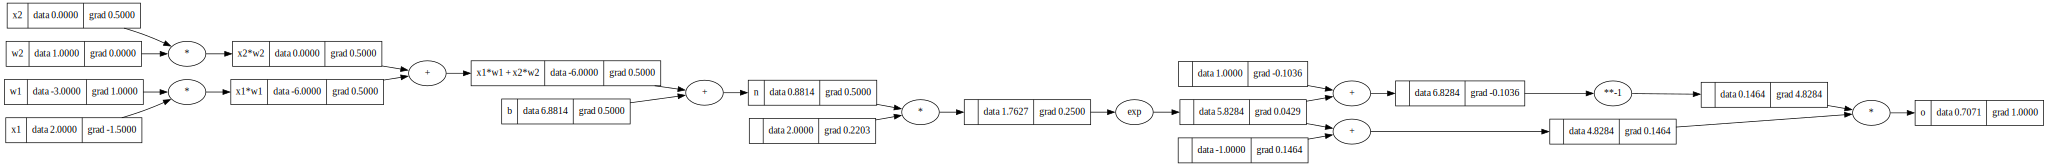

In [195]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [197]:
import torch

In [199]:
x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('----')
print('x2', x2.grad.item())
print('x1', x1.grad.item())
print('w2', w2.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
----
x2 0.5000001283844369
x1 -1.5000003851533106
w2 0.0
w1 1.0000002567688737


In [200]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [201]:
o.item()

0.7071066904050358

In [202]:
x2.grad.item()


0.5000001283844369

In [203]:
x2

tensor([0.], dtype=torch.float64, requires_grad=True)

In [248]:
import random

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
        
    def __call__(self, x):
        # w * x + b
        act = sum(wi * xi for wi, xi in zip(self.w, x)) + self.b
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        params = []
        for n in self.neurons:
            params += n.parameters()
        return params
    

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        params = []
        for l in self.layers:
            params += l.parameters()
        return params

x = [2.0, 3.0, -1]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.8445482506979523)

In [ ]:
n.parameters()

In [299]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],]

ys = [1,0, -1.0, -1.0, 1.0]

ypred = [n(x) for x in xs]
ypred

[Value(data=-0.9986152228137717),
 Value(data=-0.9985962859844548),
 Value(data=-0.9985658822753803),
 Value(data=-0.9986152779105344)]

In [251]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

In [252]:
loss

Value(data=6.979241878447911)

In [311]:
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.9999978732039243),
 Value(data=-0.9999978060380326),
 Value(data=-0.9999978995367392),
 Value(data=-0.9999979003372318)]

In [310]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=4.999987104909919)

In [258]:
n.layers[0].neurons[0].w[0].grad
n.layers[0].neurons[0].w[0].data

-0.8682600696894949

In [309]:
loss.backward()
for p in n.parameters():
    p.data += -0.1 * p.grad